# Definitions and Imports

In [1]:
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from tqdm import tqdm
import seaborn as sns

from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

np.set_printoptions(linewidth=300, suppress=True)
pd.options.mode.chained_assignment = None  # default='warn'

from src.experiments.util_experiments import *
from src.oom import DiscreteValuedOOM, ContinuousValuedOOM
from src.oom.discrete_observable import DiscreteObservable
from src.oom.util.few_step_prediction import quantify_distribution, kl_divergence, fix_pvec
from src.oom.util.random_sparse import _generate_sparse_full_rank_matrix, _generate_observable_compound
from src.oom.util.learning_discrete import estimate_matrices_discrete_fixed
from src.oom.util.learning_continuous import get_transfer_matrix

In [2]:
from src.experiments.util_experiments import get_gaussian

In [3]:
def minmaxscale(ser: pd.Series):
    return (ser - ser.min()) / (ser.max() - ser.min())

In [4]:
def compute_cross_entropy(source_oom, sequence, F_YX, indexing):
    # Note the column indexing names the rows, while row indexing names the columns
    _col, _row = indexing
    indexing_row = list(_col) # row names
    indexing_col = list(_row) # column names
    
    total_nll = 0.0
    valid_terms = 0
    
    for t in range(3, len(sequence)):
        history, next_symbol = sequence[t-3 : t], sequence[t]
        history_name = "".join([obs.uid for obs in history])
        col_idx = indexing_col.index(history_name)
        next_idx = source_oom.observables.index(next_symbol)
        
        # Get probability from F_YX
        prob = F_YX[next_idx, col_idx]
        
        # Avoid log(0) by adding a tiny epsilon (e.g., 1e-12) if necessary
        if prob == 0:
            prob = 1e-12  # Handle zero probabilities gracefully
        
        total_nll += -np.log2(prob)
        valid_terms += 1
    
    # Step 3: Compute average NLL (cross-entropy)
    H_fq3 = total_nll / valid_terms
    return H_fq3

In [5]:
def optimize_discrete(n: int, d: int, density: float, max_seeds: int) -> pd.DataFrame:
    # Define results dictionary
    metrics_dv = {
        "spectral_gap": [],
        "geo_mean_var": [],
        "perc0fs_at_7": [],
        "H_q3": [],
        "H_f": [],
        "H_uniform": []
    }

    # Iterate through first max_seeds seeds
    description = f"Discrete-Valued Source Optimization ({n=}, {d=}, {density=})"
    for DVSEED in tqdm(range(max_seeds), desc = description):
        # Create source OOM as an HMM with the given paramters for this seed
        oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = DVSEED)

        # Skip OOMs with too many zeros in the 7-step distribution
        quant7 = quantify_distribution(steps=7, state=oom_disc.start_state, operators=oom_disc.operators, lin_func=oom_disc.lin_func)
        perc0fs_at_7 = np.average(quant7 == 0)
        if perc0fs_at_7 > n**(-2):
            continue
        
        # Compute spectral gap
        transition_matrix = np.sum(oom_disc.operators, axis = 0)
        eigenvalues, _ = np.linalg.eig(transition_matrix)
        eigenvalues = np.sort(np.abs(eigenvalues))[::-1]  # Sort eigenvalues
        spectral_gap = eigenvalues[0] - eigenvalues[1]    # Spectral gap

        # Compute entropies
        gen = oom_disc.generate(10_000, reduced=False)
        nll_f = gen.nll_list[-1]
        
        estimate_matrices_3rdorder = estimate_matrices_discrete_fixed(
            sequence=gen.sequence,
            len_cwords=1,
            len_iwords=3,
            indexing=True
        )
        
        indexing = estimate_matrices_3rdorder[-1]
        F_YX_3rdorder = estimate_matrices_3rdorder[0][0]
        F_YX_3rdorder /= F_YX_3rdorder.sum(axis=0)
        nll_3rdorder = compute_cross_entropy(oom_disc, gen.sequence, F_YX_3rdorder, indexing)
    
        # Compute geometric mean of variances on PC1, PC2 axes
        pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
        pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
        x_pca = pvs_embeds_pca[:,0]
        y_pca = pvs_embeds_pca[:,1]
        var_pc1 = np.var(x_pca)
        var_pc2 = np.var(y_pca)
        geometric_mean = np.sqrt(var_pc1 * var_pc2)
        
        # Save results
        metrics_dv["spectral_gap"].append(spectral_gap)
        metrics_dv["geo_mean_var"].append(geometric_mean)
        metrics_dv["perc0fs_at_7"].append(perc0fs_at_7)
        metrics_dv["H_q3"].append(nll_3rdorder)
        metrics_dv["H_f"].append(nll_f)
        metrics_dv["H_uniform"].append(np.log2(n))

    # Convert to pandas
    df = pd.DataFrame(metrics_dv)

    ####################################
    # Criteria:
    # -> Maximize H_q3 - H_f
    # -> Maximize geo_mean_var
    # -> Minimizing H_f / H_uniform ("H_f well within [0, H_uniform]" quantified as this)
    # -> Minimize spectral_gap
    ####################################

    # Rename index column
    df = df.reset_index().rename({'index': 'DVSEED'}, axis = 1)

    # Process H_q3 - H_f, H_f / H_uniform
    df['_entropy_diff'] = df['H_q3'] - df['H_f']
    df['_uniform_perc'] = df['H_f'] / df['H_uniform']

    # Normalized values:
    # -> _entropy_diff: non-reversing and min-max scaled to [0, 1] (higher better)
    # ->  geo_mean_var: non-reversing and min-max scaled to [0, 1] (higher better)
    # -> _uniform_perc:     reversing and min-max scaled to [0, 1] (lower better)
    # ->  spectral_gap:     reversing and min-max scaled to [0, 1] (lower better)
    # ==> maximize their average
    df['_norm_entropy_diff'] =     minmaxscale(df['_entropy_diff'])
    df['_norm_geo_mean_var'] =     minmaxscale(df['geo_mean_var'])
    df['_norm_uniform_perc'] = 1 - minmaxscale(df['_uniform_perc'])
    df['_norm_spectral_gap'] = 1 - minmaxscale(df['spectral_gap'])
    df['_norm_weighted_sum'] = (df['_norm_entropy_diff'] + df['_norm_uniform_perc'] + df['_norm_geo_mean_var'] + df['_norm_spectral_gap']) / 4
    
    df = df.sort_values(['_norm_weighted_sum'], ascending=False)
    return df

In [6]:
def optimize_continuous(dvoom: DiscreteValuedOOM, max_seeds: int) -> pd.DataFrame:
    # Define results dictionary
    metrics_cv = {
        'geo_mean_var': [],
        'H_f': [],
        'H_uniform': []
    }

    d = dvoom.dim
    n = len(dvoom.observables)

    # Iterate through first max_seeds seeds
    description = f'Blended Source Optimization'
    for CVSEED in tqdm(range(max_seeds), desc = description):
        # Create source blended OOM with random Gaussians for this seed
        mfs = get_gaussian(seed = CVSEED)(n)
        oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(dvoom, mfs)

        # Compute entropies
        gen = oom_cont.generate(10_000, reduced=False)
        nll_f = gen.nll_list[-1]
    
        # Compute geometric mean of variances on PC1, PC2 axes
        pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
        pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
        x_pca = pvs_embeds_pca[:,0]
        y_pca = pvs_embeds_pca[:,1]
        var_pc1 = np.var(x_pca)
        var_pc2 = np.var(y_pca)
        geometric_mean = np.sqrt(var_pc1 * var_pc2)
        
        # Save results
        metrics_cv['geo_mean_var'].append(geometric_mean)
        metrics_cv['H_f'].append(nll_f)
        metrics_cv['H_uniform'].append(np.log2(n))

    # Convert to pandas
    df = pd.DataFrame(metrics_cv)

    ####################################
    # Criteria:
    # -> H_f well within [0, H_uniform]
    # -> Maximize geo_mean_var
    ####################################

    # Rename index column
    df = df.reset_index().rename({'index': 'CVSEED'}, axis = 1)

    # Process H_f / H_uniform
    df['_uniform_perc'] = df['H_f'] / df['H_uniform']

    # Normalized values:
    # ->  geo_mean_var: non-reversing and min-max scaled to [0, 1] (higher better)
    # -> _uniform_perc:     reversing and min-max scaled to [0, 1] (lower better)
    # ==> maximize their average
    df['_norm_geo_mean_var'] =     minmaxscale(df['geo_mean_var'])
    df['_norm_uniform_perc'] = 1 - minmaxscale(df['_uniform_perc'])
    df['_norm_weighted_sum'] = (df['_norm_geo_mean_var'] + df['_norm_uniform_perc']) / 2
    
    df = df.sort_values(['_norm_weighted_sum'], ascending=False)
    return df

In [7]:
def plot_pca_results(x_pca, y_pca, fig, ax, title, scale='auto'):
    ax.set_title(title)
    points = np.array([x_pca, y_pca]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    cols = np.linspace(0, 1, len(x_pca))

    cmap = sns.color_palette("flare", as_cmap=True)
    lc = LineCollection(segments, cmap = cmap, alpha = 0.5)
    lc.set_array(cols)
    lc.set_linewidth(0.15)
    line = ax.add_collection(lc)

    if scale == 'auto':
        ax.autoscale()
    else:
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
    
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    fig.colorbar(line, ax = ax)

def make_plot(oom, gen, fig, ax, title):
    pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
    
    pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
    
    x_pca = pvs_embeds_pca[:,0]
    y_pca = pvs_embeds_pca[:,1]
    
    plot_pca_results(x_pca, y_pca, fig, ax, title, scale=0)

def plot_mfs(cvoom, fig, ax, title, xlim = (-5, 5)):
    xlimi, xlims = xlim
    ax.set_title(title)
    ax.set_xlim([xlimi, xlims])
    
    x = np.linspace(xlimi, xlims, (xlims - xlimi) * 1000)
    for obs, mf in zip(cvoom.observables, cvoom.membership_fns):
        ax.plot(x, mf.pdf(x), label=obs.uid)
    ax.legend()

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

# Source choice code run

## S_3

In [8]:
# (n: int, d: int, density: float, max_seeds: int)
S_3_disc_df = optimize_discrete(n=3, d=10, density=0.4, max_seeds=200)

Discrete-Valued Source Optimization (n=3, d=10, density=0.4): 100%|██████████████████| 200/200 [02:52<00:00,  1.16it/s]


In [9]:
S_3_disc_df.head()

,DVSEED,spectral_gap,geo_mean_var,perc0fs_at_7,H_q3,H_f,H_uniform,_entropy_diff,_uniform_perc,_norm_entropy_diff,_norm_geo_mean_var,_norm_uniform_perc,_norm_spectral_gap,_norm_weighted_sum
95,95,0.308139,0.046038,0.000000,0.779938,0.755528,1.584963,0.024410,0.476685,1.000000,1.000000,0.880213,0.591441,0.867913
133,133,0.073037,0.016934,0.000000,0.660675,0.646761,1.584963,0.013914,0.408061,0.642468,0.361573,1.000000,1.000000,0.751010
24,24,0.166433,0.031945,0.005487,1.267953,1.253742,1.584963,0.014211,0.791023,0.652593,0.690856,0.331523,0.837697,0.628167
81,81,0.209541,0.045009,0.000000,1.186297,1.184983,1.584963,0.001315,0.747641,0.213270,0.977426,0.407248,0.762783,0.590182
35,35,0.462164,0.045104,0.000000,1.299368,1.289035,1.584963,0.010333,0.813290,0.520475,0.979509,0.292654,0.323776,0.529104


In [10]:
S_3_disc_oom = make_source(alphabet_size=3, dimension=10, density=0.4, seed=int(S_3_disc_df['DVSEED'].iloc[0]))
S_3_cont_df = optimize_continuous(dvoom=S_3_disc_oom, max_seeds=200)

Blended Source Optimization: 100%|███████████████████████████████████████████████████| 200/200 [04:18<00:00,  1.29s/it]


In [11]:
S_3_cont_df.head()

,CVSEED,geo_mean_var,H_f,H_uniform,_uniform_perc,_norm_geo_mean_var,_norm_uniform_perc,_norm_weighted_sum
85,85,0.006567,2.668012,1.584963,1.683328,1.000000,0.351264,0.675632
173,173,0.002878,1.820624,1.584963,1.148686,0.433459,0.852018,0.642739
110,110,0.005101,2.428161,1.584963,1.531999,0.774854,0.493001,0.633928
36,36,0.005791,2.624974,1.584963,1.656174,0.880738,0.376697,0.628718
133,133,0.005101,2.459855,1.584963,1.551996,0.774807,0.474272,0.624539


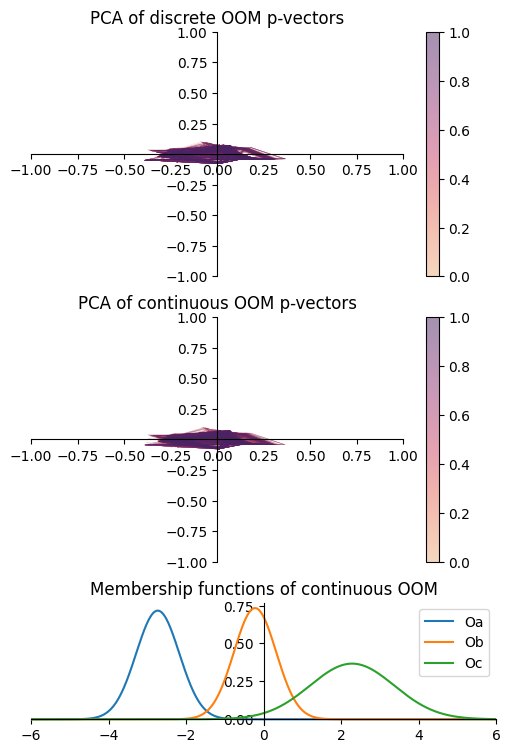

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), height_ratios=[1, 1, 0.5])
axs = axs.flatten()

# oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = 10)
# mfs = get_gaussian(seed = 10)(n)
# oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(oom_disc, mfs)
oom_disc = make_source(alphabet_size=3, dimension=10, density=0.4, seed=int(S_3_disc_df['DVSEED'].iloc[0]))
oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(
    oom_disc,
    membership_functions=get_gaussian(seed=int(S_3_cont_df['CVSEED'].iloc[0]))(len(oom_disc.observables))
)

gen_disc = oom_disc.generate(10000, reduced = False)
gen_cont = oom_cont.generate(10000, reduced = False)

make_plot(oom_disc, gen_disc, fig, axs[0], "PCA of discrete OOM p-vectors")
make_plot(oom_cont, gen_cont, fig, axs[1], "PCA of continuous OOM p-vectors")
plot_mfs(oom_cont, fig, axs[2], "Membership functions of continuous OOM", xlim=(-6, 6))

[[ 1.9726657  -0.01074164  0.00108882]
 [-0.01074164  1.95028737 -0.29459914]
 [ 0.00108882 -0.29459914  3.89490496]]
[[0.50694349 0.00280272 0.00007027]
 [0.00280272 0.51868641 0.03923113]
 [0.00007027 0.03923113 0.25971298]]


<Axes: >

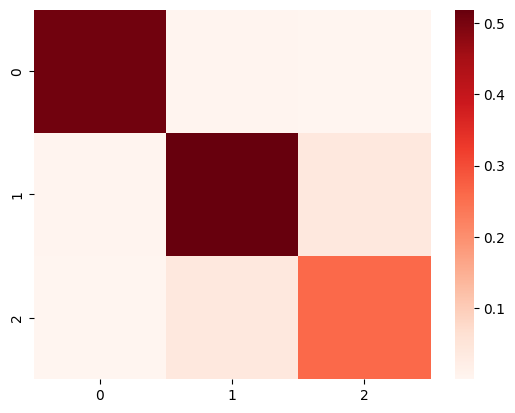

In [13]:
T_inv_3 = get_transfer_matrix(
    mfn_dict = dict(zip(range(3), get_gaussian(seed=int(S_3_cont_df['CVSEED'].iloc[0]))(3))),
    save_to_files=False
)
print(T_inv_3)
print(np.linalg.inv(T_inv_3))
sns.heatmap(np.linalg.inv(T_inv_3), cmap="Reds")

In [22]:
S_3_disc_df.to_csv('../data/source_seeds/S_3_discrete_ranking.csv', index=False)
S_3_cont_df.to_csv('../data/source_seeds/S_3_blended_ranking.csv', index=False)

## S_5

In [14]:
# (n: int, d: int, density: float, max_seeds: int)
S_5_disc_df = optimize_discrete(n=5, d=10, density=0.4, max_seeds=200)

Discrete-Valued Source Optimization (n=5, d=10, density=0.4): 100%|██████████████████| 200/200 [08:53<00:00,  2.67s/it]


In [15]:
S_5_disc_df.head()

,DVSEED,spectral_gap,geo_mean_var,perc0fs_at_7,H_q3,H_f,H_uniform,_entropy_diff,_uniform_perc,_norm_entropy_diff,_norm_geo_mean_var,_norm_uniform_perc,_norm_spectral_gap,_norm_weighted_sum
79,79,0.073037,0.027426,0.000038,0.883481,0.903628,2.321928,-0.020147,0.389172,0.513486,0.649370,1.000000,1.000000,0.790714
13,13,0.289279,0.039639,0.022502,1.595291,1.594944,2.321928,0.000347,0.686905,1.000000,0.954462,0.494213,0.624216,0.768223
15,15,0.166433,0.018993,0.011827,1.922854,1.941755,2.321928,-0.018900,0.836268,0.543087,0.438732,0.240476,0.837697,0.514998
87,87,0.468967,0.041312,0.000000,1.865858,1.887860,2.321928,-0.022002,0.813057,0.469460,0.996252,0.279907,0.311954,0.514393
0,0,0.379462,0.028629,0.000000,1.643002,1.670744,2.321928,-0.027742,0.719550,0.333206,0.679421,0.438755,0.467495,0.479720


In [16]:
S_5_disc_oom = make_source(alphabet_size=5, dimension=10, density=0.4, seed=int(S_5_disc_df['DVSEED'].iloc[0]))
S_5_cont_df = optimize_continuous(dvoom=S_5_disc_oom, max_seeds=200)

Blended Source Optimization: 100%|███████████████████████████████████████████████████| 200/200 [04:35<00:00,  1.38s/it]


In [17]:
S_5_cont_df.head()

,CVSEED,geo_mean_var,H_f,H_uniform,_uniform_perc,_norm_geo_mean_var,_norm_uniform_perc,_norm_weighted_sum
130,130,0.005964,2.745131,2.321928,1.182264,1.000000,0.432934,0.716467
152,152,0.005767,2.767339,2.321928,1.191828,0.966269,0.415989,0.691129
105,105,0.005102,2.630736,2.321928,1.132996,0.852185,0.520218,0.686201
151,151,0.004870,2.606125,2.321928,1.122397,0.812389,0.538996,0.675693
137,137,0.002611,2.236636,2.321928,0.963267,0.424762,0.820916,0.622839


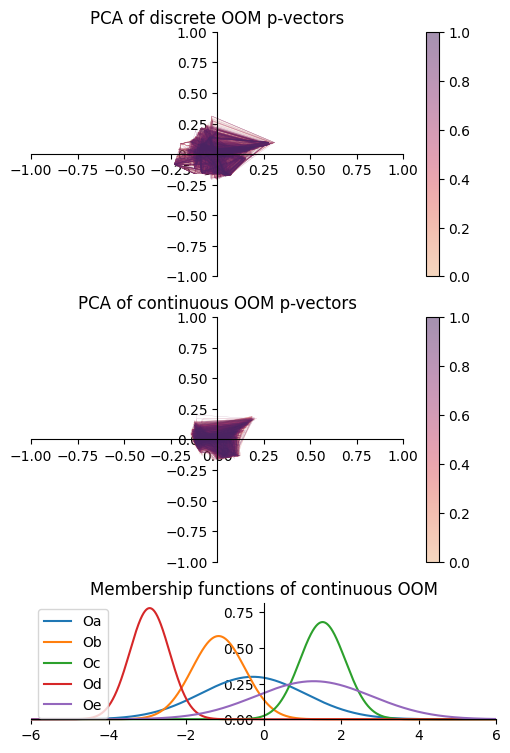

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), height_ratios=[1, 1, 0.5])
axs = axs.flatten()

# oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = 10)
# mfs = get_gaussian(seed = 10)(n)
# oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(oom_disc, mfs)
oom_disc = make_source(alphabet_size=5, dimension=10, density=0.4, seed=int(S_5_disc_df['DVSEED'].iloc[0]))
oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(
    oom_disc,
    membership_functions=get_gaussian(seed=int(S_5_cont_df['CVSEED'].iloc[0]))(len(oom_disc.observables))
)

gen_disc = oom_disc.generate(10000, reduced = False)
gen_cont = oom_cont.generate(10000, reduced = False)

make_plot(oom_disc, gen_disc, fig, axs[0], "PCA of discrete OOM p-vectors")
make_plot(oom_cont, gen_cont, fig, axs[1], "PCA of continuous OOM p-vectors")
plot_mfs(oom_cont, fig, axs[2], "Membership functions of continuous OOM", xlim=(-6, 6))

[[  3.06573679  -0.01336418  -0.0045864    0.67860453  -2.31175294]
 [ -0.01336418   3.66285553  -0.42670728  -7.42057162   5.20818477]
 [ -0.0045864   -0.42670728   3.90512743   0.56883781  -0.38937367]
 [  0.67860453  -7.42057162   0.56883781  32.5607006  -23.97340159]
 [ -2.31175294   5.20818477  -0.38937367 -23.97340159  20.69439859]]
[[0.50694349 0.00280272 0.00007027 0.2124742  0.30206666]
 [0.00280272 0.51868641 0.03923113 0.15045345 0.04480541]
 [0.00007027 0.03923113 0.25971298 0.00500638 0.00082074]
 [0.2124742  0.15045345 0.00500638 0.34099622 0.38099137]
 [0.30206666 0.04480541 0.00082074 0.38099137 0.51216406]]


<Axes: >

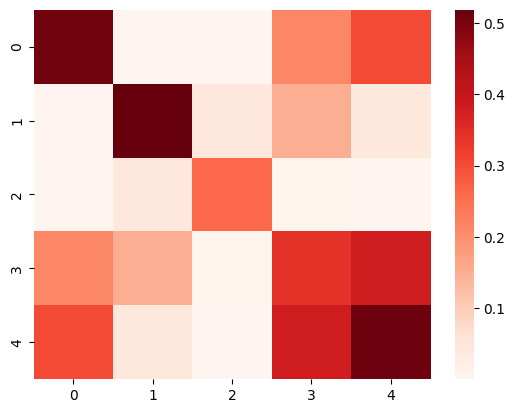

In [19]:
T_inv_5 = get_transfer_matrix(
    mfn_dict = dict(zip(range(5), get_gaussian(seed=int(S_3_cont_df['CVSEED'].iloc[0]))(5))),
    save_to_files=False
)
print(T_inv_5)
print(np.linalg.inv(T_inv_5))
sns.heatmap(np.linalg.inv(T_inv_5), cmap="Reds")

In [23]:
S_5_disc_df.to_csv('../data/source_seeds/S_5_discrete_ranking.csv', index=False)
S_5_cont_df.to_csv('../data/source_seeds/S_5_blended_ranking.csv', index=False)